## Imports

In [1]:
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # read and manipulate local files


import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score as f1_score_report

import time
from tqdm import tqdm

import random
# from PIL import Image

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow.keras as ks
import tensorflow as tf
# from tensorflow.keras.applications import xception, MobileNet, MobileNetV2, Xception, Xception, EfficientNetV2M, InceptionV3
# from tensorflow.keras.applications import EfficientNetB2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa # elastic_deformation

from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Dense, BatchNormalization, Concatenate, GlobalAveragePooling2D
from keras.initializers import RandomNormal# weights will be initialized according to a Gaussian distribution 

# hide wornings
import warnings
warnings.filterwarnings('ignore')

################################################################################################
# SETTING F1 SCORE
from tensorflow_addons.metrics import F1Score
f1_score = F1Score(num_classes=13, average='macro')

In [2]:
model_name = 'InceptionV3'#'MobileNet' #'Xception'#    'InceptionV3'##'T2TViT', , 'MobileNet', 'Xception', 

################################################################################################

## SEETING THE PATHS
PATH_TO_CODE =''
sys.path.append(PATH_TO_CODE)
DATASET_PATH = '../paddy-doctor-diseases-small-split/'
# DATASET_PATH =  '../paddy-doctor-diseases-small-400-split/'
DATASET_PATH_TRAIN = os.path.join(DATASET_PATH, 'train')
DATASET_PATH_TEST = os.path.join(DATASET_PATH, 'test')


PATH_TO_SAVE_RESULT = os.path.join(PATH_TO_CODE, 'saved_outputs_no_augment', model_name)
PATH_BEST_SAVE_WEIGHT = os.path.join(PATH_TO_SAVE_RESULT,'saved_weights')
PATH_TO_SAVE_MODEL = os.path.join(PATH_TO_SAVE_RESULT, 'saved_models')
PATH_SAVE_HISTORY = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_training_history.csv')
PATH_SAVE_TIME = os.path.join(PATH_TO_SAVE_RESULT, model_name+'training_time.csv')
# PATH_TO_SAVE_TUNER = os.path.join(PATH_TO_RESULT, 'saved_tuner_model')
################################################################################################


IMG_HEIGHT = 256
IMG_WIDTH = 256
ORIGINAL_IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
COLOR_CHANNEL = 3

RESIZE_SHAPE = (128, 128)
MODEL_INPUT_SIZE = (RESIZE_SHAPE[0], RESIZE_SHAPE[1], COLOR_CHANNEL)

VALIDATION_SPLIT= 0.2
NUM_CLASSES = 13 #len(target_labels) # 13

BATCH_SIZE = 64
EPOCHS = 120 #120
# EXTRA_RUN_AFTER_BEST_EPOCH = 10

################################################################################################
AUGMENT = False
AUGMENT_TYPE = 'basic' # basic, advanced,
################################################################################################

# METRICS_TO_RECORD = 'short'#'full' #'short'  # "full" or 'short'
SAVE_RESULTS = True
SHOW_RESULTS = True

################################################################################################
# Setting the seed
SEED  = 123
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

################################################################################################
# Checkpoint parameters
SCORE_TO_MONITOR = 'val_f1_score' # Score that checkpoints monitor during training
SCORE_OBJECTIVE  = 'max'          # 'max' or 'min', specifies whether the objective is to maximize the score or minimize it. 

PATIENCE_EARLY_STOP = 15
# Checkpoint parameters
REDUCTION_FACTOR = 0.5            # Factor which lr will be reduced with at plateau
EPOCH_PATIENCE_LR_INCREASE = 5              # For how many epochs must the score plateau before reducing lr
MIN_LR = 1e-8
INITIAL_LR=0.0001
# COOLDOWN_EPOCHS  = 5              # How many epochs to wait after learning rate reduction before it can be reduced again

In [3]:
print("DATASET_PATH", DATASET_PATH)
print("DATASET_PATH_TRAIN", DATASET_PATH_TRAIN)
print("DATASET_PATH_TEST", DATASET_PATH_TEST)

print("PATH_TO_SAVE_RESULT",PATH_TO_SAVE_RESULT)
print("PATH_BEST_SAVE_WEIGHT", PATH_BEST_SAVE_WEIGHT)
print("PATH_TO_SAVE_MODEL", PATH_TO_SAVE_MODEL)

DATASET_PATH ../paddy-doctor-diseases-small-split/
DATASET_PATH_TRAIN ../paddy-doctor-diseases-small-split/train
DATASET_PATH_TEST ../paddy-doctor-diseases-small-split/test
PATH_TO_SAVE_RESULT saved_outputs_no_augment\InceptionV3
PATH_BEST_SAVE_WEIGHT saved_outputs_no_augment\InceptionV3\saved_weights
PATH_TO_SAVE_MODEL saved_outputs_no_augment\InceptionV3\saved_models


## Using GPU

In [4]:
# Check if GPU is available
print("GPU Available: ", tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Num GPUs Available:  2


## Image Data Augmentation Options in Keras `ImageDataGenerator`

The Keras `ImageDataGenerator` offers various options for image augmentation, enhancing training dataset diversity and improving model robustness. Below is a list of common augmentations available:

1. **`rotation_range`**: Degrees range (0-180) for random rotations.

2. **`width_shift_range` & `height_shift_range`**: Fraction of total width or height, or an integer number of pixels, for horizontal or vertical image shift.

3. **`brightness_range`**: Tuple specifying a range for random brightness adjustment. Values < 1 darken the image, > 1 brighten it.

4. **`shear_range`**: Shear Intensity (angle in counter-clockwise direction as radians) for shear transformations.

5. **`zoom_range`**: Range for random zoom. If a float, `[lower, upper] = [1-zoom_range, 1+zoom_range]`.

6. **`channel_shift_range`**: Range for random channel (color) shifts.

7. **`fill_mode`**: Mode for filling points outside boundaries ('constant', 'nearest', 'reflect', 'wrap') after transformations.

8. **`cval`**: Value for filling points outside boundaries when `fill_mode` is 'constant'.

9. **`horizontal_flip` & `vertical_flip`**: Boolean. Randomly flip images horizontally or vertically.

10. **`rescale`**: Rescaling factor, often 1/255 to scale pixel values to [0, 1].

11. **`preprocessing_function`**: Function to be applied to each input after resizing and augmenting.

12. **`validation_split`**: Fraction of images reserved for validation (between 0 and 1).

13. **`dtype`**: Dtype to use for generated arrays.

Note: The appropriateness of these augmentations depends on the specific data and use case. Some, like flipping, may not suit certain types of images (e.g., text).

### ElasticTransformation

In [5]:
# Define an augmentation pipeline
# Alpha parameter controls the intensity of the deformation
# Sigma controls the smoothness of the deformation field.
aug = iaa.Sequential([  
    iaa.ElasticTransformation(alpha=50, sigma=10)  # Apply elastic transformations , sigma=1
])

def elastic_deformation(image):
    image_aug = aug(image=image)
    return image_aug

In [6]:
# Defining a function for creating the generators with given augmentation type
# images are alreagy rescaled--so no rescaling is needed
def create_generators(dataset_path_train=DATASET_PATH_TRAIN, 
                      dataset_path_test=DATASET_PATH_TEST, 
                      valid_ratio=VALIDATION_SPLIT, 
                      augment= False, 
                      augment_type='all'):
   
    # If augmentation is True, apply data augmentation. Otherwise, only rescale.
    if augment:
        if augment_type == 'all':     
            datagen = ImageDataGenerator(
                rescale=1./255, # Normalize images
                validation_split=valid_ratio,  # Split ratio for validation set

                # Geometric Transformations
                rotation_range=40,  # degrees
                width_shift_range=0.2,  # fraction of total width
                height_shift_range=0.3,  # fraction of total height
                shear_range=0.4,  # shear angle in counter-clockwise direction as radians
                zoom_range=0.25,  # zoom range for random zoom
                horizontal_flip=True,  # randomly flip images horizontally
                vertical_flip=True,  # randomly flip images vertically
                
                # Pixel-Level Transformations
                brightness_range=[0.6, 1.1],  # range for picking a brightness shift value
                channel_shift_range=0.3,  # range for random channel shifts

                # Advanced functions
                preprocessing_function=elastic_deformation
            )
        elif augment_type == 'basic':     
            datagen = ImageDataGenerator(
                rescale=1./255, # Normalize images
                validation_split=valid_ratio,  # Split ratio for validation set

                # Geometric Transformations
                rotation_range=40,  # degrees
                horizontal_flip=True,  # randomly flip images horizontally
            )
        elif augment_type == 'advanced':     
            datagen = ImageDataGenerator(
                rescale=1./255, # Normalize images
                validation_split=valid_ratio,  # Split ratio for validation set

                # Advanced functions
                preprocessing_function=elastic_deformation
            )
            
    else:
        # No augmentation
        datagen = ImageDataGenerator(
            validation_split=valid_ratio,  # Split ratio for validation set
            rescale=1./255, # Normalize images
        )
    
    # Create training generator
    train_generator = datagen.flow_from_directory(
        dataset_path_train,
        batch_size=BATCH_SIZE,
        seed = SEED,
        class_mode="categorical",  # Use "categorical" for multi-class classification
        target_size=RESIZE_SHAPE,  # Adjust target size based on your model requirements
        shuffle = True,
        color_mode = 'rgb',
        subset='training'  # Specify subset as 'training'
    )
    
    # Create validation generator
    valid_generator = datagen.flow_from_directory(
        dataset_path_train,
        batch_size=BATCH_SIZE,
        seed = SEED,
        class_mode="categorical",  # Use "categorical" for multi-class classification
        target_size=RESIZE_SHAPE,  # Adjust target size based on your model requirements        
        shuffle = True,        
        color_mode = 'rgb',
        subset='validation'  # Specify subset as 'validation'
    )
    
    # For the test set, assuming no augmentation, just rescaling
    test_datagen = ImageDataGenerator(
                rescale=1./255# Normalize images
    )
    test_generator = test_datagen.flow_from_directory(
        dataset_path_test,
        class_mode="categorical",  # Use "categorical" for multi-class classification
        target_size=RESIZE_SHAPE,  # Adjust target size based on your model requirements        
        seed = SEED,
        shuffle = False,        
        color_mode = 'rgb',
        batch_size=BATCH_SIZE)
    
    return train_generator, valid_generator, test_generator

In [7]:
# Creating the generators using functions
train_generator, valid_generator, test_generator = create_generators(dataset_path_train=DATASET_PATH_TRAIN,
                                                                     dataset_path_test = DATASET_PATH_TEST,
                                                                     augment=AUGMENT,
                                                                     augment_type = AUGMENT_TYPE,
                                                                     valid_ratio = VALIDATION_SPLIT)

Found 10389 images belonging to 13 classes.
Found 2591 images belonging to 13 classes.
Found 3245 images belonging to 13 classes.


## Essential functions (training)

In [8]:
def fit_and_save_best_model(model_name, model, epochs=EPOCHS):
    ##########################################################################################################
    saved_best_model_name = 'best_'+model_name+'.h5'
    # Criteria for early stopping
    EarlyStop_callback = EarlyStopping(min_delta=0.001, patience=PATIENCE_EARLY_STOP, restore_best_weights=True)

    model_saving_path = os.path.join(PATH_TO_SAVE_MODEL, saved_best_model_name)
    # Set up a model checkpoint to save the best model during training
    best_model_callback= ModelCheckpoint(model_saving_path,
                                          monitor=SCORE_TO_MONITOR, 
                                          save_best_only=True,
                                          mode=SCORE_OBJECTIVE, 
                                          verbose=1)

    # Setup the ReduceLROnPlateau callback
    reduce_LR = ReduceLROnPlateau(
        factor=REDUCTION_FACTOR,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=EPOCH_PATIENCE_LR_INCREASE,      # Number of epochs with no improvement after which learning rate will be reduced.
        verbose=1,       # int. 0: quiet, 1: update messages.
        min_lr=MIN_LR    # Lower bound on the learning rate.
    )

    my_callbacks = [best_model_callback , reduce_LR, EarlyStop_callback]
    ##########################################################################################################

    start_time = time.time()
    # Fitting the model
    train_history = model.fit(
        train_generator,
        epochs= epochs,
        batch_size=BATCH_SIZE,
        validation_data=valid_generator,
        callbacks=my_callbacks,
    )

    total_time = time.time() -start_time
    return saved_best_model_name, train_history, total_time

## Essential functions (saving result)

In [9]:
def plot_training_history(training_history_object, list_of_metrics=None):
    """
    Input:
        training_history_object:: Object returned by model.fit() function in keras
        list_of_metrics        :: A list of metrics to be plotted. Use if you only
                                  want to plot a subset of the total set of metrics
                                  in the training history object. By Default it will
                                  plot all of them in individual subplots.
    """
    history_dict = training_history_object.history

    ###################ADDDED NEW################################################
    # Remove 'lr' and 'val_lr' keys from history_dict if they exist
    history_dict.pop('lr', None)
    history_dict.pop('val_lr', None)
    #############################################################################
    
    if list_of_metrics is None:
        list_of_metrics = [key for key in list(history_dict.keys()) if 'val_' not in key]
    trainHistDF = pd.DataFrame(history_dict)
    # trainHistDF.head()
    train_keys = list_of_metrics
    valid_keys = ['val_' + key for key in train_keys]
    nr_plots = len(train_keys)
    fig, ax = plt.subplots(1,nr_plots,figsize=(5*nr_plots,4))
    for i in range(len(train_keys)):
        ax[i].plot(np.array(trainHistDF[train_keys[i]]), label='Training')
        ax[i].plot(np.array(trainHistDF[valid_keys[i]]), label='Validation')
        ax[i].set_xlabel('Epoch')
        ax[i].set_title(train_keys[i])
        ax[i].grid('on')
        ax[i].legend()
    fig.tight_layout
    # plt.show()

    if SAVE_RESULTS:
        # Save the plot to a PDF
        pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_training_history.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig(fig)
            if SHOW_RESULTS:
                plt.show()
            else:
                plt.close()

In [10]:
def show_save_confusion_matrix(predicted_labels, target_labels):
    cm = confusion_matrix(target_labels, predicted_labels)
    
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='g',  cmap='Greens')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    # plt.show()

    # Save the plot to a PDF
    if SAVE_RESULTS:
        pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_confusion_matrix.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig()  # saves the current figure into a pdf page
            # plt.close()
            if SHOW_RESULTS:
                plt.show()
            else:
                plt.close()

In [11]:
def calculate_TF_TP_FP_FN(true_labels_y_test, predicted_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels_y_test, predicted_labels)
    
    class_to_performance_data = {}
    # Calculate TP, FP, TN, FN for each class
    num_classes = cm.shape[0]
    for cls in range(num_classes):
        TP = cm[cls, cls]
        FP = cm[:, cls].sum() - TP
        FN = cm[cls, :].sum() - TP
        TN = cm.sum() - (FP + FN + TP)
        
        # Calculate support for each class
        support = TP + FN
        
        class_to_performance_data[cls] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN, 'Support': support}
    return class_to_performance_data


def calculate_metrics(class_to_performance_data, accuracy, SHOW_RESULTS=True, SAVE_RESULTS=True):
    metrics_summary = {
        'overall':{},
        'Macro': {},
        'Weighted': {}
    }

    metrics_summary[ 'overall']= {'accuracy': accuracy}

    # Lists to store metric values for macro averaging
    precision_list, recall_list, f1_score_list = [], [], []
    fpr_list, fnr_list, fdr_list, npv_list = [], [], [], []
    
    # Variables for weighted sum of metrics
    weighted_precision, weighted_recall, weighted_f1 = 0, 0, 0
    weighted_fpr, weighted_fnr, weighted_fdr, weighted_npv = 0, 0, 0, 0
    total_support = 0

    # Calculate metrics for each class
    for class_id, metrics in class_to_performance_data.items():
        tp = metrics['TP']
        fp = metrics['FP']
        tn = metrics['TN']
        fn = metrics['FN']
        support = metrics['Support']

        # Basic evaluation metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Additional evaluation metrics
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        # Append to lists for macro averaging
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        fpr_list.append(fpr)
        fnr_list.append(fnr)
        fdr_list.append(fdr)
        npv_list.append(npv)

        # Weighted sum of metrics
        weighted_precision += precision * support
        weighted_recall += recall * support
        weighted_f1 += f1_score * support
        weighted_fpr += fpr * support
        weighted_fnr += fnr * support
        weighted_fdr += fdr * support
        weighted_npv += npv * support
        total_support += support

    # Calculate macro averages and round to 5 decimal places
    metrics_summary['Macro']['Precision'] = round(sum(precision_list) / len(precision_list), 5)
    metrics_summary['Macro']['Recall'] = round(sum(recall_list) / len(recall_list), 5)
    metrics_summary['Macro']['F1-Score'] = round(sum(f1_score_list) / len(f1_score_list), 5)
    metrics_summary['Macro']['FPR'] = round(sum(fpr_list) / len(fpr_list), 5)
    metrics_summary['Macro']['FNR'] = round(sum(fnr_list) / len(fnr_list), 5)
    metrics_summary['Macro']['FDR'] = round(sum(fdr_list) / len(fdr_list), 5)
    metrics_summary['Macro']['NPV'] = round(sum(npv_list) / len(npv_list), 5)

    # Calculate weighted averages and round to 5 decimal places
    if total_support > 0:
        metrics_summary['Weighted']['Precision'] = round(weighted_precision / total_support, 5)
        metrics_summary['Weighted']['Recall'] = round(weighted_recall / total_support, 5)
        metrics_summary['Weighted']['F1-Score'] = round(weighted_f1 / total_support, 5)
        metrics_summary['Weighted']['FPR'] = round(weighted_fpr / total_support, 5)
        metrics_summary['Weighted']['FNR'] = round(weighted_fnr / total_support, 5)
        metrics_summary['Weighted']['FDR'] = round(weighted_fdr / total_support, 5)
        metrics_summary['Weighted']['NPV'] = round(weighted_npv / total_support, 5)

    # Convert the nested dictionary into a DataFrame
    report_df = pd.DataFrame.from_dict({(i+" "+j): metrics_summary[i][j]  for i in metrics_summary.keys()  for j in metrics_summary[i].keys()}, orient='index').reset_index()
    # Rename columns for clarity
    report_df.columns = ['Metric Type', 'Value']    
    if SHOW_RESULTS:
        display(report_df)

    if SAVE_RESULTS:      
        prediction_report_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_all_performance_report.csv" )
        # Save the DataFrame to a CSV file
        report_df.to_csv(prediction_report_filename, index=True)
 
    # return metrics_summary

def calculate_accuracy(true_labels_y_test, predicted_labels):
    # Ensure the inputs are NumPy arrays for element-wise comparison
    true_labels_y_test = np.array(true_labels_y_test)
    predicted_labels = np.array(predicted_labels)
    
    # Calculate the number of correct predictions
    correct_predictions = np.sum(true_labels_y_test == predicted_labels)
    
    # Calculate the total number of predictions
    total_predictions = len(true_labels_y_test)
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    
    # Round accuracy to 5 decimal places
    accuracy = round(accuracy, 5)
    
    return accuracy

In [12]:
def store_classification_report(predicted_labels, target_labels):
    report_dict = classification_report(target_labels, predicted_labels, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    if SHOW_RESULTS:
        display(report_df)

    if SAVE_RESULTS:        
        prediction_report_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_classification_report.csv" )
        # Save the DataFrame to a CSV file
        report_df.to_csv(prediction_report_filename, index=True)

In [13]:
def show_save_test_results(test_generator, best_model):
    # Evaluate the model on test data
    test_loss, test_accuracy, test_f1_score = best_model.evaluate(test_generator) 
    
    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    # print(f"Test F1 Score: {test_f1_score}")
    
    test_results = {
        'model_name': model_name,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1_score
    }

        # Convert the dictionary to a DataFrame
    report_df = pd.DataFrame([test_results])
    
    if SHOW_RESULTS:
        display(report_df)
    
    if SAVE_RESULTS:
        path_to_save = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_model_performance.csv")
        # Save the DataFrame to a CSV file
        report_df.to_csv(path_to_save , index=False)
        del report_df, test_results
    return  test_loss

In [14]:
def calculate_test_performance_metrics_all(predicted_labels, target_labels, test_loss):
    # Calculate metrics
    accuracy = accuracy_score(target_labels, predicted_labels)
    precision_macro = precision_score(target_labels, predicted_labels, average='macro')
    recall_macro = recall_score(target_labels, predicted_labels, average='macro')
    f1_macro = f1_score_report(target_labels, predicted_labels, average='macro')

    precision_weighted = precision_score(target_labels, predicted_labels, average='weighted')
    recall_weighted = recall_score(target_labels, predicted_labels, average='weighted')
    f1_weighted = f1_score_report(target_labels, predicted_labels, average='weighted')    
    
    # Create a dictionary to hold the metrics
    test_results = {
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Macro Precision': precision_macro,
        'Macro Recall': recall_macro,
        'Macro F1-Score': f1_macro,
        'Weighted Precision': precision_weighted,
        'Weighted Recall': recall_weighted,
        'Weighted F1-Score': f1_weighted,        
        'Loss': test_loss
    }
    
        # Convert the dictionary to a DataFrame
    report_df = pd.DataFrame([test_results])
    
    if SHOW_RESULTS:
        display(report_df)

    if SAVE_RESULTS:
        path_to_save = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_model_all_test_performance.csv")
        # Save the DataFrame to a CSV file
        report_df.to_csv(path_to_save , index=False)
        
    del report_df, test_results

## MODEL CREATING

In [16]:
from tensorflow.keras.applications import InceptionV3
def get_InceptionV3(): 
 
    # model = Sequential()
    # base_model = InceptionV3(input_shape=MODEL_INPUT_SIZE, include_top=False, weights=None)
    
    # # Global average pooling and additional dense layers
    # x = Flatten()(base_model.output)
    # # x = Dense(512, activation='relu')(x)
    # predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # # Build the functional model
    # model = Model(inputs=base_model.input, outputs=predictions)
    model = InceptionV3(input_shape=MODEL_INPUT_SIZE,  weights=None, classes=NUM_CLASSES)

    optimizer = Adam(learning_rate=INITIAL_LR)
    model.compile(loss="categorical_crossentropy", 
                  metrics=['accuracy', f1_score],
                  optimizer=optimizer)
    return model

# Train and Results 16

In [22]:
# if model_name=='DenseNet121':
#     model= get_DenseNet121()
# elif model_name=='MobileNet':
#     model= get_MobileNet_original()
# elif model_name=='Xception':
#     model= get_Xception()
# elif model_name=='InceptionV3':
#     model= get_InceptionV3()

# ##Getting the model
# model= get_MobileNet_original()
# model= get_DenseNet121()
# model= get_Xception()
model= get_InceptionV3()
# model = get_cait()
# # ## Getting the model
# model = get_basic_CNN() 


In [23]:
# training the model and saving the best model as a check point---0-120
best_model_name, train_history, total_time = fit_and_save_best_model(model_name, model)

Epoch 1/120
163/163 [==============================] - ETA: 0s - loss: 1.9845 - accuracy: 0.3446 - f1_score: 0.2540
Epoch 1: val_f1_score improved from -inf to 0.01986, saving model to saved_outputs_no_augment\InceptionV3\saved_models\best_InceptionV3.h5
163/163 [==============================] - 71s 342ms/step - loss: 1.9845 - accuracy: 0.3446 - f1_score: 0.2540 - val_loss: 3.3799 - val_accuracy: 0.1482 - val_f1_score: 0.0199 - lr: 1.0000e-04
Epoch 2/120
163/163 [==============================] - ETA: 0s - loss: 1.4690 - accuracy: 0.5164 - f1_score: 0.4617
Epoch 2: val_f1_score improved from 0.01986 to 0.03051, saving model to saved_outputs_no_augment\InceptionV3\saved_models\best_InceptionV3.h5
163/163 [==============================] - 55s 336ms/step - loss: 1.4690 - accuracy: 0.5164 - f1_score: 0.4617 - val_loss: 4.0737 - val_accuracy: 0.1440 - val_f1_score: 0.0305 - lr: 1.0000e-04
Epoch 3/120
163/163 [==============================] - ETA: 0s - loss: 1.1293 - accuracy: 0.6351 - f1

In [24]:
# Saving the time to be reused
time_data = {
    "model_name": [model_name],
    "run_time": [total_time]
}

# Convert the dictionary to a pandas DataFrame
time_df = pd.DataFrame(time_data)

# Save the DataFrame to a CSV file
time_df.to_csv(PATH_SAVE_TIME, index=False)

In [25]:
# Saving the history as csv file to be reused
history_df = pd.DataFrame(train_history.history)
history_df.to_csv(PATH_SAVE_HISTORY, index=False)

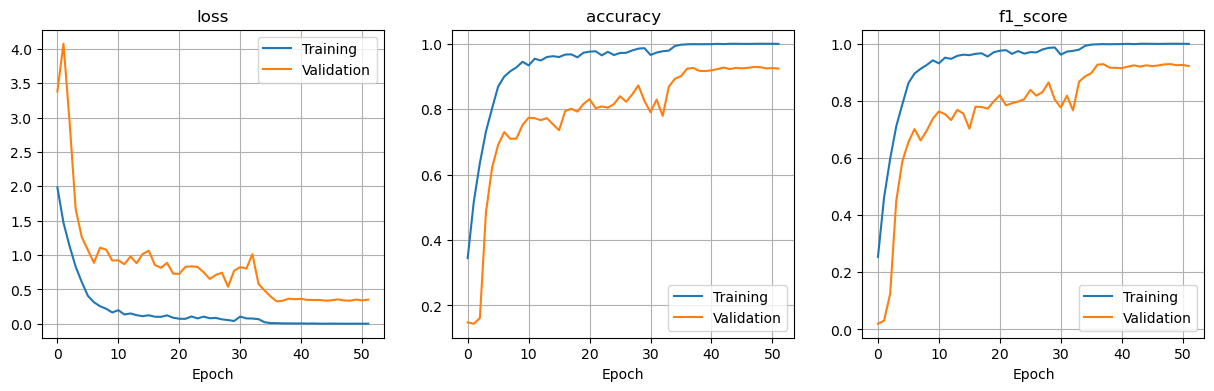

In [26]:
# plotting train history
plot_training_history(train_history)

In [27]:
# Now, load the best model
best_model = ks.models.load_model(os.path.join(PATH_TO_SAVE_MODEL, best_model_name), custom_objects={'F1Score': F1Score})

In [28]:
# Use the best model for Test results: loss, accuracy, f1_score
test_loss = show_save_test_results(test_generator, best_model)

51/51 [==============================] - 10s 146ms/step - loss: 0.3233 - accuracy: 0.9322 - f1_score: 0.9285


,model_name,test_loss,test_accuracy,test_f1_score
0,InceptionV3,0.323283,0.932203,0.928454


In [29]:
# Get predictions from the model
predictions = best_model.predict(test_generator, verbose=1)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

true_labels_y_test =  np.array(test_generator.classes) # y_test  
############################################################################################################]

51/51 [==============================] - 12s 189ms/step


In [30]:
# # Classification report
store_classification_report(predicted_labels=predicted_labels, 
                            target_labels=true_labels_y_test)

,precision,recall,f1-score,support
0,0.933333,0.861538,0.896000,130.000000
1,0.959184,0.940000,0.949495,100.000000
2,0.921348,0.911111,0.916201,90.000000
3,0.911765,0.920792,0.916256,101.000000
4,0.942675,0.944681,0.943677,470.000000
5,0.904215,0.932806,0.918288,253.000000
6,0.918129,0.902299,0.910145,174.000000
7,0.925408,0.921114,0.923256,431.000000
8,0.929577,0.904110,0.916667,219.000000
9,0.929719,0.962578,0.945863,481.000000


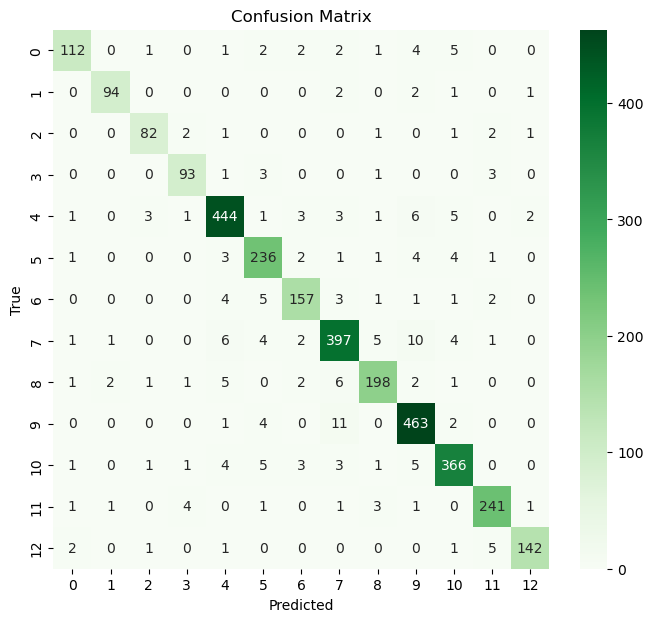

In [31]:
# For saving confusion matrix
show_save_confusion_matrix(predicted_labels=predicted_labels, 
                           target_labels=true_labels_y_test)

In [32]:
# # Calculate all
calculate_test_performance_metrics_all(predicted_labels=predicted_labels, 
                                       target_labels=true_labels_y_test,
                                       test_loss=test_loss)

,Model Name,Accuracy,Macro Precision,Macro Recall,Macro F1-Score,Weighted Precision,Weighted Recall,Weighted F1-Score,Loss
0,InceptionV3,0.932203,0.9325,0.924809,0.928453,0.93233,0.932203,0.932116,0.323283


In [33]:
data = calculate_TF_TP_FP_FN(true_labels_y_test, predicted_labels)
acc = calculate_accuracy(true_labels_y_test, predicted_labels)
calculate_metrics(class_to_performance_data=data, accuracy=acc)

,Metric Type,Value
0,overall accuracy,0.93220
1,Macro Precision,0.93250
2,Macro Recall,0.92481
3,Macro F1-Score,0.92845
4,Macro FPR,0.00582
5,Macro FNR,0.07519
6,Macro FDR,0.06750
7,Macro NPV,0.99424
8,Weighted Precision,0.93233
9,Weighted Recall,0.93220
